### Introduction

In [ ]:
######################################################################
# Setup working directory
######################################################################
%mkdir -p /content/aps360_project/baseline/
%cd /content/aps360_project/baseline/

######################################################################
# Helper functions for loading data
######################################################################
# adapted from
# https://github.com/fchollet/keras/blob/master/keras/datasets/cifar10.py

import os
import pickle
import sys
import tarfile

import numpy as np
from PIL import Image
from six.moves.urllib.request import urlretrieve


def get_file(fname, origin, untar=False, extract=False, archive_format="auto", cache_dir="data"):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + ".tar.gz"
    else:
        fpath = os.path.join(datadir, fname)

    print("File path: %s" % fpath)
    if not os.path.exists(fpath):
        print("Downloading data from", origin)

        error_msg = "URL fetch failure on {}: {} -- {}"
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print("Extracting file.")
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    if extract:
        _extract_archive(fpath, datadir, archive_format)

    return fpath


def load_batch(fpath, label_key="labels"):
    """Internal utility for parsing CIFAR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    f = open(fpath, "rb")
    if sys.version_info < (3,):
        d = pickle.load(f)
    else:
        d = pickle.load(f, encoding="bytes")
        # decode utf8
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode("utf8")] = v
        d = d_decoded
    f.close()
    data = d["data"]
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels


def load_cifar10(transpose=False):
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    dirname = "cifar-10-batches-py"
    origin = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    path = get_file(dirname, origin=origin, untar=True)

    num_train_samples = 50000

    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype="uint8")
    y_train = np.zeros((num_train_samples,), dtype="uint8")

    for i in range(1, 6):
        fpath = os.path.join(path, "data_batch_" + str(i))
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000 : i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000 : i * 10000] = labels

    fpath = os.path.join(path, "test_batch")
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if transpose:
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)
    return (x_train, y_train), (x_test, y_test)

4/1AY0e-g4AupJ6MXTSUSuws94TLwIPHvNMXc18yjuKnevU3teXxH0UXvgg4z0/content/aps360_project/baseline


In [ ]:
# Download and import libraries
!pip install torch torchvision matplotlib numpy scikit-image pillow==4.1.1

In [ ]:
# Move data into training and validation directories
from google.colab import drive
drive.mount('/content/drive')

import os
train_path = '/content/drive/MyDrive/Colab Notebooks/horseTrainOuter/' 
val_path = '/content/drive/MyDrive/Colab Notebooks/houseValOuter/'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import argparse
import math
import time
from skimage.color import lab2rgb, rgb2lab, rgb2gray
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import scipy.misc
import torch
import torchvision.models as models
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
%matplotlib inline
from skimage import io
import os, shutil

In [ ]:
use_gpu = torch.cuda.is_available()
#Image colorisation of convolution neural network
#https://lukemelas.github.io/image-colorization.html
#Regression model was performing too poorly, so used an online code as we wanted to move on to better models. Everything below other than dataloading taken from this link

In [ ]:
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    resnet = models.resnet18(num_classes=365) 
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    midlevel_features = self.midlevel_resnet(input)

    output = self.upsample(midlevel_features)
    return output

In [ ]:
model = ColorizationNet()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0)

In [ ]:
class GrayscaleImageFolder(datasets.ImageFolder):
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    if self.transform is not None:
      img_original = self.transform(img)
      img_original = np.asarray(img_original)
      img_lab = rgb2lab(img_original)
      img_lab = (img_lab + 128) / 255
      img_ab = img_lab[:, :, 1:3]
      img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
      img_original = rgb2gray(img_original)
      img_original = torch.from_numpy(img_original).unsqueeze(0).float()
    if self.target_transform is not None:
      target = self.target_transform(target)
    return img_original, img_ab, target

In [ ]:
# Training
#train_transforms = transforms.Compose([transforms.RandomResizedCrop(32), transforms.RandomHorizontalFlip()])
#train_imagefolder = GrayscaleImageFolder(train_path, train_transforms)
#train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=64, shuffle=True)

 #train_loader,val_loader= get_data_loader(batch_size=64)
#val_transforms = transforms.Compose([transforms.Resize(32), transforms.CenterCrop(32)])
#val_imagefolder = GrayscaleImageFolder(val_path , val_transforms)
#val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=64, shuffle=False)

In [ ]:
def get_data_loader(batch_size=64):
    # defining the path of the train and val data

    train_path = '/content/drive/MyDrive/Colab Notebooks/horseTrainOuter/' 
    val_path = '/content/drive/MyDrive/Colab Notebooks/houseValOuter/'
    
    # defining the transformation that needs to take place - resize and tensor
    train_transforms = transforms.Compose([transforms.RandomResizedCrop(32), 
                                           transforms.RandomHorizontalFlip()])
    
    val_transforms = transforms.Compose([transforms.Resize(32), transforms.CenterCrop(32)])


    
    # getting the datasets
    train_dataset = GrayscaleImageFolder(root=train_path, transform=train_transforms)
    val_dataset = GrayscaleImageFolder(root=val_path, transform=val_transforms)

    # getting the loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, num_workers=0, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, num_workers=0, batch_size=batch_size, shuffle=True)
 
    print("Data loading is complete")
    return train_loader, val_loader

In [ ]:
 train_loader,val_loader= get_data_loader(batch_size=64)

Data loading is complete


In [ ]:
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial''' 
  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  plt.clf() # clear matplotlib 
  color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image.astype(np.float64))
  grayscale_input = grayscale_input.squeeze().numpy()
  if save_path is not None and save_name is not None: 
    plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
    plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

In [ ]:
def validate(val_loader, model, criterion, save_images, epoch):
  model.eval()

  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  already_saved_images = False
  for i, (input_gray, input_ab, target) in enumerate(val_loader):
    data_time.update(time.time() - end)

    # Use GPU
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Run model and record loss
    output_ab = model(input_gray) # throw away class predictions
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))

    # Save images to file
    if save_images and not already_saved_images:
      already_saved_images = True
      for j in range(min(len(output_ab), 10)): # save at most 5 images
        save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 25 == 0:
      print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i, len(val_loader), batch_time=batch_time, loss=losses))

  print('Finished validation.')
  return losses.avg

In [ ]:
model = ColorizationNet()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0)

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch):
  print('Starting training epoch {}'.format(epoch))
  model.train()
  
  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  for i, (input_gray, input_ab, target) in enumerate(train_loader):
    
    # Use GPU if available
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Record time to load data (above)
    data_time.update(time.time() - end)

    # Run forward pass
    output_ab = model(input_gray) 
    loss = criterion(output_ab, input_ab) 
    losses.update(loss.item(), input_gray.size(0))

    # Compute gradient and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record time to do forward and backward passes
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to value, not validation
    if i % 25 == 0:
      print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
              epoch, i, len(train_loader), batch_time=batch_time,
             data_time=data_time, loss=losses)) 

  print('Finished training epoch {}'.format(epoch))
  return losses.avg

Next, we define a training loop and we train for 100 epochs:

In [ ]:
if use_gpu: 
  criterion = criterion.cuda()
  model = model.cuda()

In [ ]:
# Make folders and set parameters
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
save_images = True
best_losses = 1e10
epochs = 100

In [ ]:
# Train model
lossGraphVal = []
lossGraphTrain = []
for epoch in range(epochs):
  
  # Train for one epoch, then validate
  lossesTrain = train(train_loader, model, criterion, optimizer, epoch)
  with torch.no_grad():
    losses = validate(val_loader, model, criterion, save_images, epoch)
  # Save checkpoint and replace old best model if current model is better
    lossGraphTrain.append(lossesTrain)
    lossGraphVal.append(losses)
  if losses < best_losses:
    best_losses = losses
    torch.save(model.state_dict(), 'checkpoints/model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1,losses))

Starting training epoch 0
Epoch: [0][0/79]	Time 17.423 (17.423)	Data 17.412 (17.412)	Loss 0.5104 (0.5104)	
Epoch: [0][25/79]	Time 18.423 (17.740)	Data 18.413 (17.729)	Loss 0.0104 (0.1555)	
Epoch: [0][50/79]	Time 16.623 (17.549)	Data 16.612 (17.539)	Loss 0.0033 (0.0825)	
Epoch: [0][75/79]	Time 18.351 (17.570)	Data 18.341 (17.559)	Loss 0.0024 (0.0563)	
Finished training epoch 0
Validate: [0/16]	Time 18.775 (18.775)	Loss 0.0023 (0.0023)	
Finished validation.
Starting training epoch 1
Epoch: [1][0/79]	Time 0.128 (0.128)	Data 0.117 (0.117)	Loss 0.0020 (0.0020)	
Epoch: [1][25/79]	Time 0.130 (0.130)	Data 0.119 (0.120)	Loss 0.0024 (0.0022)	
Epoch: [1][50/79]	Time 0.126 (0.129)	Data 0.116 (0.119)	Loss 0.0023 (0.0022)	
Epoch: [1][75/79]	Time 0.132 (0.131)	Data 0.121 (0.120)	Loss 0.0018 (0.0022)	
Finished training epoch 1
Validate: [0/16]	Time 0.134 (0.134)	Loss 0.0023 (0.0023)	
Finished validation.
Starting training epoch 2
Epoch: [2][0/79]	Time 0.127 (0.127)	Data 0.116 (0.116)	Loss 0.0021 (0.00

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 8 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Finished validation.
Starting training epoch 29
Epoch: [29][0/79]	Time 0.128 (0.128)	Data 0.117 (0.117)	Loss 0.0020 (0.0020)	
Epoch: [29][25/79]	Time 0.150 (0.131)	Data 0.139 (0.121)	Loss 0.0020 (0.0020)	
Epoch: [29][50/79]	Time 0.126 (0.132)	Data 0.115 (0.121)	Loss 0.0017 (0.0019)	
Epoch: [29][75/79]	Time 0.128 (0.131)	Data 0.118 (0.121)	Loss 0.0019 (0.0019)	
Finished training epoch 29
Validate: [0/16]	Time 0.134 (0.134)	Loss 0.0020 (0.0020)	
Finished validation.
Starting training epoch 30
Epoch: [30][0/79]	Time 0.128 (0.128)	Data 0.118 (0.118)	Loss 0.0022 (0.0022)	
Epoch: [30][25/79]	Time 0.127 (0.130)	Data 0.117 (0.119)	Loss 0.0016 (0.0018)	
Epoch: [30][50/79]	Time 0.132 (0.129)	Data 0.121 (0.119)	Loss 0.0017 (0.0018)	
Epoch: [30][75/79]	Time 0.127 (0.129)	Data 0.116 (0.119)	Loss 0.0017 (0.0018)	
Finished training epoch 30
Validate: [0/16]	Time 0.130 (0.130)	Loss 0.0023 (0.0023)	
Finished validation.
Starting training epoch 31
Epoch: [31][0/79]	Time 0.130 (0.130)	Data 0.120 (0.120)	

<Figure size 432x288 with 0 Axes>

100


Text(0.5, 0, 'Epochs')

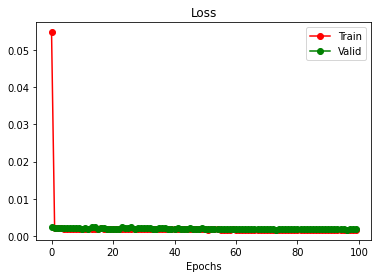

In [ ]:
print(len(lossGraphVal))
plt.figure()
plt.plot(lossGraphTrain, "ro-", label="Train")
plt.plot(lossGraphVal, "go-", label="Valid")
plt.legend()
plt.title("Loss")
plt.xlabel("Epochs")



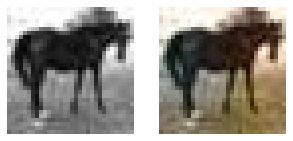

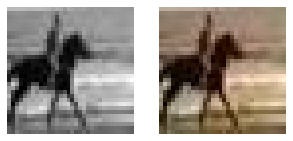

In [ ]:
# Show images 
import matplotlib.image as mpimg
image_pairs = [('outputs/color/img-2-epoch-0.jpg', 'outputs/gray/img-2-epoch-0.jpg'),
               ('outputs/color/img-7-epoch-0.jpg', 'outputs/gray/img-7-epoch-0.jpg')]
for c, g in image_pairs:
  color = mpimg.imread(c)
  gray  = mpimg.imread(g)
  f, axarr = plt.subplots(1, 2)
  f.set_size_inches(5, 5)
  axarr[0].imshow(gray, cmap='gray')
  axarr[1].imshow(color)
  axarr[0].axis('off'), axarr[1].axis('off')
  plt.show()

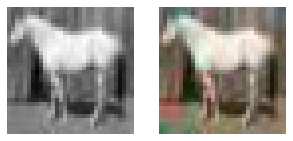

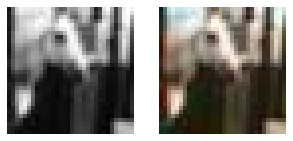

In [ ]:
# Show images 
import matplotlib.image as mpimg
image_pairs = [('outputs/color/img-2-epoch-0.jpg', 'outputs/gray/img-2-epoch-0.jpg'),
               ('outputs/color/img-7-epoch-0.jpg', 'outputs/gray/img-7-epoch-0.jpg')]
for c, g in image_pairs:
  color = mpimg.imread(c)
  gray  = mpimg.imread(g)
  f, axarr = plt.subplots(1, 2)
  f.set_size_inches(5, 5)
  axarr[0].imshow(gray, cmap='gray')
  axarr[1].imshow(color)
  axarr[0].axis('off'), axarr[1].axis('off')
  plt.show()